# Deep expert regression networks
This script demonstrates how a deep learning engineer would set up a neural network for local expert regression. It relies on the Keras high-level deep learning API and the functions I wrote in `deepexpert`, which are available [here](https://github.com/nnormandin/DeepExperts) on github.

### Load modules
Keras for easy architecture and training, matplotlib for plotting, numpy for simple numerical operations, and `deepexpert` for the functions used in my research.

In [1]:
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.datasets import boston_housing
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import deepexpert as dx
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


### Set parameters
The basic parameters we'll use here are:
- `n_breaks`: the number of local experts (ie. the granularity of the probabilities in the forecasted CDF)
- `singe_output`: determines whether or not the local expert branches are concatenated before loss calculation
- `n_epochs`: the number of epochs that the model will be trained for
- `opt`: the optimization algorithm used to fit the model parameters

In [2]:
n_breaks = 10
single_output = True
n_epochs = 300
opt = 'adam'

### Import  data
We'll use the well-known Boston Housing data for this experiment, which we can import directly through Keras. We also reshape the `y` and `y_test` arrays for model training.

In [3]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

### Generate target sequences
Our original task is to approximate a function that maps our feature vector $\vec{x}$ to our target variable $y$, but we're now mapping our vector $\vec{x}$ to a vector of binary target values $\vec{y_b}$. The `dx.Indicator` function takes the original target vector and the number of breaks as an argument. The test data can also optionally be provided.

In [4]:
y_vecs, y_testvecs, breaks = dx.Indicator(y_train, n_breaks, stack = True, y_test = y_test)

### Defining basic network architecture
The Keras API lets us define a model using very compact code. After a simple `Input` layer we alternate fully connected layers with ReLU activation functions and `Dropout` layers.

In [5]:
input_layer = Input((x_train.shape[1],), name = 'input')
x = Dense(64, activation = 'relu')(input_layer)
x = Dropout(.5)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(.75)(x)
x = Dense(32, activation = 'relu')(x)

### Deep expert layer 
After the two shared `Dense` and `Dropout` layers, the network representation forks into 10 separate paths. The simplest way for the architecture to work at this point would be for a single fully-connected layer to map the data representation to a class affiliation probability using a sigmoid activation function. Instead, I'll extend the network by adding two additional `Dense` layers to each branch of the network. As losses backpropagate through the network, each individual local expert will share the first layers, but will be able to freely adjust the specific parameters in the final two layers that correspond to their output. The overall flow of data through the network for a single local expert will look like this:

$$ Dense(64)_{shared} \rightarrow Dropout(0.5) \rightarrow Dense(64)_{shared} \rightarrow Dropout(0.75) \rightarrow Dense(32)_{shared} \rightarrow Dense(32)_{LE} \rightarrow Dense(16)_{LE} \rightarrow Output $$

In [6]:
output = dx.DeepExpertLayer(x, n_breaks, depth = 3, widths = [32, 16])

### Architecture visualization
We can define and plot the model architecture here, showing the distinction between a common set of shared layers and the forking local expert branches. In this version, all of the model outputs are concatenated into a single sequence in order to easily compute the sum of binary cross entropy.

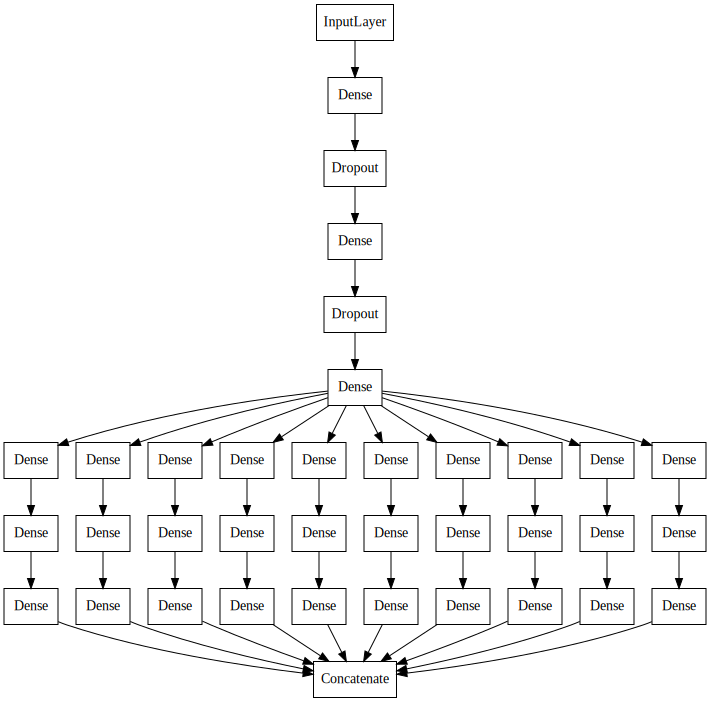

In [12]:
mod = Model(input_layer, output)
SVG(model_to_dot(mod, show_layer_names=False).create(prog='dot', format='svg'))

### Fit model
With the model architecture fully defined, we can compile and train it. I use binary cross entropy loss and conduct parameter search using the `Adam` optimizer.

In [8]:
mod.compile(optimizer = opt, loss = 'binary_crossentropy')
mod.fit(x_train, y_vecs, verbose = 0,
		validation_data = (x_test, y_testvecs),
		epochs = n_epochs, batch_size = 16)

### Model predictions
The network now produces a sequences of probabilities that we can reconstruct to form a CDF. We can predict probabilities for all of the instances in the test partition and plot an example.

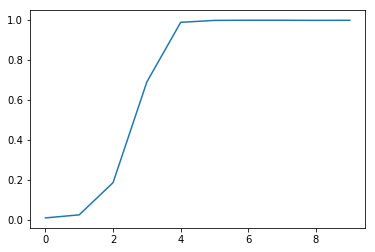

In [9]:
test_preds = mod.predict(x_test)
plt.plot(test_preds[1])
plt.show()